<center><h1> <u>Projet IOT : Géolocalisation d'appareils connectés sans GPS </u> </h1></center>

<center><img src='https://www.capgemini.com/wp-content/uploads/2015/07/IoT.jpg'><center>


Groupe :

    - Cyrille Nouboué
    - Di Léa Wu
    - Sebastien David 
    - Imane Aghmari


### <u> Desription </u>  :

In the project of **INF730-Internet of things with Big Data**, we use Machine Learning skills to detect the device position (latitude, longitude), with the help of **RSS technologie**.

The training data includes the information concerning the message (base station position, received power, SNR...). The prediction will be the device's exact latitude and longitude.

### Problem :
What kind of machine learning problems do we have?

* We want to predict the exact value of latitude and longtitude, so it's a linear regression problem. There are lots of resolutions, for exemple random forest, KNN, light GBM etc.
    
* Since there are lots of base stations as features and each line concerns one base station, we are working on a sparse matrix. In order to resolve this problem, the dataset will be grouped by message id, so that each line contains several base station reception information.


In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import plot_tree
import graphviz
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import plotly.express as px
from sklearn import neighbors

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. <u>Load Data :</u>

In [0]:
# load train and test data
df_mess_train = pd.read_csv('/content/drive/My Drive/IOT /mess_train_list.csv')
df_mess_test = pd.read_csv('/content/drive/My Drive/IOT /mess_test_list.csv')
pos_train = pd.read_csv('/content/drive/My Drive/IOT /pos_train_list.csv')

# <center>2. <u>Data exploration :</u></center>

### 2.1 <u>Base station on map</u>

In [4]:
fig = px.scatter_mapbox(df_mess_train, lat="bs_lat", lon="bs_lng", zoom=3, height=800,color_discrete_sequence=["fuchsia"]) #
fig.update_layout(mapbox_style="stamen-terrain")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### 2.2 <u>Explore dataset</u>

In [5]:
# explore data 
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [6]:
# explore message position dataset
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


### 2.3 <u>Base station coverage in train and test dataset :</u>

We need to know if all the base stations in the test dataset are in the training dataset.

In [0]:
# find out the list of base station in train and test dataset
bs_train = df_mess_train['bsid'].unique()
bs_test = df_mess_test['bsid'].unique()

In [0]:
# find out the base station which is in the test but not in train
diff = np.setdiff1d(bs_test, bs_train)

<b><u>Conclusion</u>:</b> 
8 base stations in the test dataset are not in the train dataset.

### 2.4 <u> Base station reception distribution</u> : 

To see the recepted message number for each base station: 

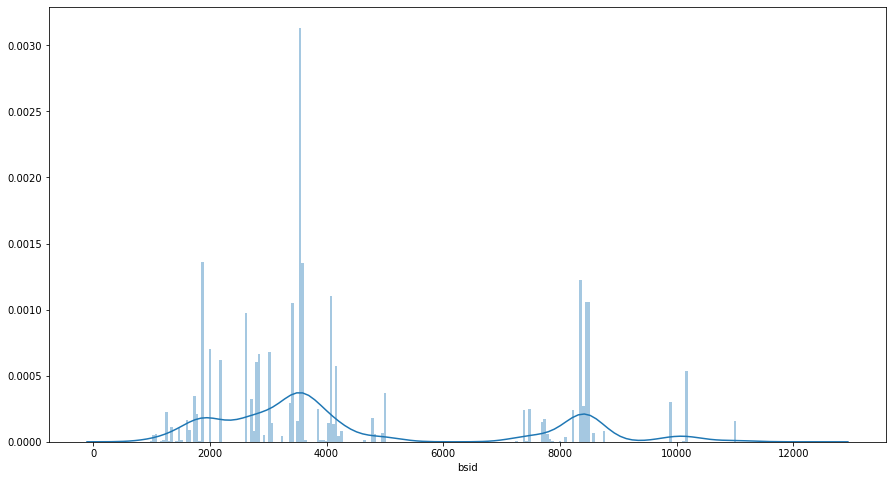

In [9]:
bs = df_mess_train['bsid']
bs_len = df_mess_train.groupby('bsid')['bsid'].count()
plt.figure(figsize=(15,8))
sns.distplot(bs, bins = len(bs_len))

<b> <u>Conclusion</u>:</b>
We can see that only a half of the base station are in active status about receiving messages.

# <center> 3. <u> Correlation : </u> </center>  

In [0]:
df_cor = df_mess_train.join(pos_train)

In [0]:
# Correlation matrix
corr_all = df_cor.corr()

In [0]:
# Generate a mask for the down triangle of our correlation matrix
mask = np.zeros_like(corr_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

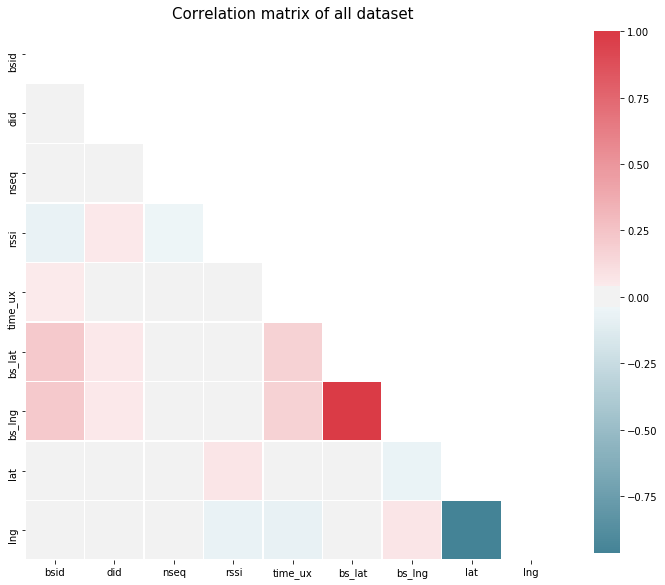

In [13]:
#Let's plot the figure
f, ax1 = plt.subplots(1,1, figsize=(12,12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, ax =ax1 )

ax1.set_title("Correlation matrix of all dataset", fontsize= 15)
plt.show()

Conclusion: we can see that the message latitude and longtitude have a strong correlation with rssi and time_ux as well as bs_lng.

# <center> 4. <u> Detect abnormal device </u> : </center> 

In [14]:
df = pd.concat((df_mess_train, pos_train), axis = 1)
df['dif_lat'] = (df.bs_lat - df.lat)**2
df['dif_lng'] = (df.bs_lng - df.lng)**2
df['dist'] = np.sqrt(df['dif_lat']+df['dif_lng'])
df.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,dif_lat,dif_lng,dist
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000,39250.000000,39250.000000,3.925000e+04,3.925000e+04,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685,39.783333,-105.056343,6.741506e+01,1.492287e+02,4.989718
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732,0.206262,0.162954,1.897790e+02,4.205467e+02,13.847432
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146,35.770683,-107.630679,3.485689e-14,3.003040e-13,0.000240
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287,39.708599,-105.060463,1.049923e-04,1.001859e-04,0.023027
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685,39.776882,-105.039440,7.325228e-04,7.132148e-04,0.048259
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429,39.805279,-105.018730,5.229332e-03,4.260058e-03,0.100110
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000,43.140387,-102.094289,6.131994e+02,1.487353e+03,44.351127


In [15]:
df2 = df.groupby('did').mean()
device_out = df2[df2['dist']>10].index
df2.describe()

,bsid,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,dif_lat,dif_lng,dist
count,113.000000,113.000000,113.000000,1.130000e+02,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
mean,4609.128870,1.028531,-126.000047,1.471268e+12,41.356622,-102.927079,39.857706,-105.149020,36.371461,80.479149,2.734260
std,896.329490,0.215263,3.443866,5.437579e+09,2.223198,3.421136,0.278510,0.213699,55.153183,122.225780,4.033276
min,1012.000000,0.000000,-132.583333,1.463588e+12,39.356127,-106.547933,39.337005,-106.581243,0.000037,0.000198,0.015952
25%,4022.931540,0.986842,-127.919048,1.466548e+12,39.824071,-105.163254,39.775998,-105.215511,0.003224,0.003077,0.071527
50%,4474.666667,1.031250,-126.348958,1.470575e+12,39.943505,-105.090760,39.817627,-105.147682,0.008638,0.011347,0.110691
75%,5152.509158,1.109015,-125.083333,1.475528e+12,42.344503,-101.106614,39.852670,-105.036086,64.911217,143.127194,4.771515
max,6693.384615,1.750000,-105.000000,1.481115e+12,51.931234,-86.934415,41.902645,-104.777094,297.802367,661.619610,21.820837


We can see from the tabel that the maximum value of dist is 21, which is abnormal. It's linked probably to the dysfunctional of the device. In the training, we need to elimite this device information.

In [0]:
df = df[df['did'].isin(device_out)==False]

In [0]:
df_mess_train = df[['messid','bsid','nseq','rssi','time_ux','bs_lat','bs_lng']]
pos_train = df[['lat', 'lng']]

In [18]:
df_mess_train

,messid,bsid,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,0.5,-121.500000,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,2.0,-125.000000,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,1.0,-134.000000,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,2.0,-132.000000,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,1.0,-120.000000,1.463553e+12,39.723151,-104.956216
...,...,...,...,...,...,...,...
39245,5848672e12f14360d7942374,3410,1.0,-128.000000,1.481140e+12,39.777690,-105.002424
39246,5848672e12f14360d7942374,8352,0.0,-121.000000,1.481140e+12,39.761633,-105.025753
39247,5848672e12f14360d7942374,8397,2.0,-126.000000,1.481140e+12,39.759396,-105.001415
39248,58487473e541cd0e133cca72,3051,1.0,-131.333333,1.481143e+12,39.898872,-105.153832


# <center> 5. <u> Feature Matrix construction </u> : </center> 

Since the same message can be received by several base stations, the training dataset lists multiple times for one message ID, and each line with same message ID precise a reception at a different base station. 

However, our objective is to predict the transmition position of a message. So we regroup the reception information for all base stations of one message ID in order to make each training set more completed. 

### 5.1 <u>Features transformation : </u>

The base station is transformed into column features. And the RSSI, time, base station position for each base station are also transformed into column features. The base station information will be grouped by message ID.

In [19]:
# concatenate train and test dataset to get all base station in the dataset
df = pd.concat([df_mess_train,df_mess_test])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [0]:
# transform the base station and its' ralevant information into columns so that one line contrains all information of each message 
bsid = pd.get_dummies(df['bsid'],prefix='bsid')
rssi = pd.get_dummies(df['bsid'],prefix='rssi').multiply(df["rssi"], axis="index")
time_ux = pd.get_dummies(df['bsid'],prefix='time').multiply(df["time_ux"], axis="index")
bs_lat = pd.get_dummies(df['bsid'],prefix='blat').multiply(df["bs_lat"], axis="index")
bs_lng = pd.get_dummies(df['bsid'],prefix='blng').multiply(df["bs_lng"], axis="index")

In [0]:
df = df.drop(['did', 'bsid', 'nseq', 'rssi', 'time_ux', 'bs_lat', 'bs_lng'], axis=1)
df = pd.concat([df, bsid, rssi, time_ux, bs_lat, bs_lng], axis=1)

In [0]:
df_train = df[0:len(df_mess_train)]
df_train = df_train.groupby('messid').sum()
df_test = df[len(df_mess_train):]
df_test = df_test.groupby('messid').sum()

In [23]:
df_train

,bsid_879,bsid_911,bsid_921,bsid_944,bsid_980,bsid_1012,bsid_1086,bsid_1092,bsid_1120,bsid_1131,bsid_1148,bsid_1156,bsid_1187,bsid_1226,bsid_1229,bsid_1235,bsid_1237,bsid_1264,bsid_1266,bsid_1268,bsid_1292,bsid_1334,bsid_1344,bsid_1432,bsid_1443,bsid_1447,bsid_1463,bsid_1476,bsid_1526,bsid_1530,bsid_1534,bsid_1581,bsid_1594,bsid_1661,bsid_1730,bsid_1741,bsid_1743,bsid_1772,bsid_1796,bsid_1826,...,blng_8384,blng_8390,blng_8392,blng_8397,blng_8401,blng_8405,blng_8426,blng_8437,blng_8442,blng_8446,blng_8449,blng_8450,blng_8451,blng_8452,blng_8453,blng_8457,blng_8470,blng_8471,blng_8472,blng_8473,blng_8474,blng_8475,blng_8495,blng_8509,blng_8560,blng_8746,blng_8747,blng_9783,blng_9784,blng_9899,blng_9936,blng_9941,blng_9949,blng_10134,blng_10148,blng_10151,blng_10162,blng_10999,blng_11007,blng_11951
messid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
573bf1d9864fce1a9af8c5c9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573bf3533e952e19126b256a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573c0cd0f0fe6e735a699b93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-104.973651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573c1272f0fe6e735a6cb8bd,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573c8ea8864fce1a9a5fbf7a,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,-105.001415,0.0,0.0,-104.970864,-105.074287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-105.165355,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-105.026605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5848551912f14360d786ede6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,-105.001415,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58485a25e541cd0e1329b8d6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58485bd412f14360d78bebdb,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,-105.001415,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-105.026605,0.0,0.0,0.0,0.0,0.0,-68.5,0.0,0.0,-68.5,0.0


### 5.2 <u> Build ground truth : </u>

We will drop the duplicate message ID as well as for position dataset.

In [0]:
#training dataset
ground_truth = pd.concat([df_mess_train, pos_train], axis=1, sort=False).drop_duplicates(subset = "messid", keep = 'first')[["messid", "lat", "lng"]]
ground_truth_lat = ground_truth.lat
ground_truth_lng = ground_truth.lng

# <center> 6. <u> Use Cross Validation to test models </u> : </center>

In [0]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [0]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

## 5.1 <u> Random Forest  : </u>

We decided to train by random forest model, since the random forest model fits most of our case. We decided explore the maximum depth with this model to find out the best performance.

In [0]:
vec = []
parameters = (20,30,40,50,60,70)
err = []

for i in parameters:
  # define model
  clf_lat = RandomForestRegressor(n_estimators = i)
  clf_lng = RandomForestRegressor(n_estimators = i)

  # train
  pred_lat = cross_val_predict(clf_lat, df_train, ground_truth_lat)
  pred_lng = cross_val_predict(clf_lng, df_train, ground_truth_lng)

  # append error
  err_vec = Eval_geoloc(ground_truth_lat , ground_truth_lng, pred_lat, pred_lng)
  vec.append(np.percentile(err_vec, 80))
  err.append(err_vec)



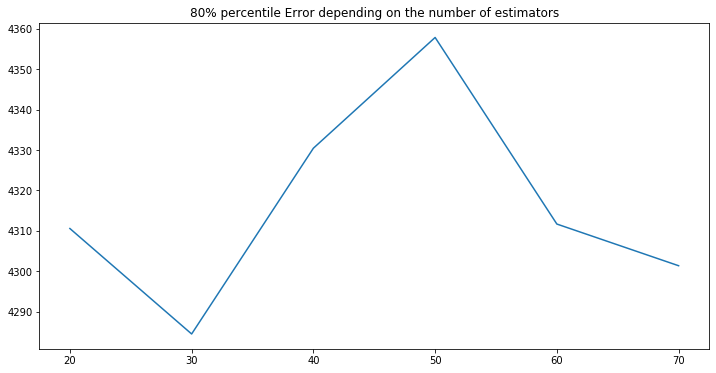

In [41]:
plt.figure(figsize=(12,6))
plt.plot([20,30,40,50,60,70], vec)
plt.title('80% percentile Error depending on the number of estimators')
plt.show()

Conclusion: 
We can see that the best model has 'number of estimators' equals to 30. So we are going to use this value for the next model.

### Rejoindre lat et lng 

Since the message position is a point with latitude and longtitude, we consider that these two values are related in some way. So we want to find out the performance by combining the latitude and longtitude together for the model prediction.

In [0]:
# combine latitude and longtitude
ground_truth_pos_train = ground_truth[['lat','lng']]

In [0]:
# therefore we only need to train 1 model 

clf_pos = RandomForestRegressor(n_estimators=30)

pred_clf = cross_val_predict(clf_pos, df_train, ground_truth_pos_train, cv=5)

In [0]:
pred_clf_lat = pred_clf[:,0]
pred_clf_lng = pred_clf[:,1]

4178.579321532756

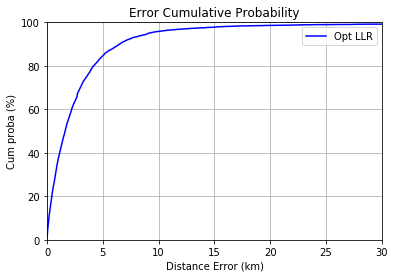

In [76]:
err_vec = Eval_geoloc(ground_truth_lat, ground_truth_lng, pred_clf_lat, pred_clf_lng)
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
# Error criterion
np.percentile(err_vec, 80)

Conclusion: 
We can see that the performance on grouping the message latitude and longtitude are better. Because latitude and longtitude information are actually relative for position.
So we are going to select this model for the Random Forest.

## KNN

In [0]:
knn_lat = neighbors.KNeighborsRegressor()
knn_lng = neighbors.KNeighborsRegressor()

pred_lat_knn = cross_val_predict(clf_lat, df_train, ground_truth_lat, cv=5)
pred_lng_knn = cross_val_predict(clf_lng, df_train, ground_truth_lng, cv=5)

4325.258109177927

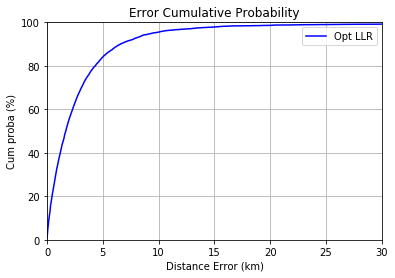

In [47]:
err_vec = Eval_geoloc(ground_truth_lat, ground_truth_lng, pred_lat_knn, pred_lng_knn)
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
# Error criterion
np.percentile(err_vec, 80)

<strong>Conclusion:
<br/>The best model is the random forest with number of estimators equals to 30 and wrap up the latitude and longtitude together in the model. This makes sense because we can see in the correlation matrix table that the latitude and longtitdue are related.

# Leave 1 device out

In order to avoid overfitting, we decided to get 1 device out of the training dataset. In other to keep a trade-off between avoid overfitting and information lose, we select one device which has an average importance. Inspired by the histogram shown before, we want to select a device with percentage of reception message between 0.0002 and 0.00025.

In [48]:
bs_dist = df_mess_train.groupby('bsid')['bsid'].sum()/sum(df_mess_train.groupby('bsid')['bsid'].sum())
bs_dist[(bs_dist<0.00025) & (bs_dist>0.0002)]

bsid
1092    0.000209
3501    0.000209
4065    0.000219
Name: bsid, dtype: float64

So we remove the device 4065 for both datasets.

In [0]:
device_id_out = 4065

In [0]:
df_device_out = df_mess_train.drop(df_mess_train.index[df_mess_train['bsid'] == 4065].tolist())

In [0]:
pos_train_device_out = pos_train.drop(pos_train.index[df_mess_train['bsid'] == 4065].tolist())

We redo the features construction since the features are changed.

In [0]:
 #ground truth
ground_truth_device_out = pd.concat([df_device_out, pos_train_device_out], axis=1, sort=False).drop_duplicates(subset = "messid", keep = 'first')[["messid", "lat", "lng"]].set_index('messid')
ground_truth_lat_device_out = ground_truth_device_out.lat
ground_truth_lng_device_out = ground_truth_device_out.lng

In [62]:
ground_truth_device_out.head()

,lat,lng
messid,,
573bf1d9864fce1a9af8c5c9,39.606690,-104.958490
573bf3533e952e19126b256a,39.637741,-104.958554
573c0cd0f0fe6e735a699b93,39.730417,-104.968940
573c1272f0fe6e735a6cb8bd,39.693102,-105.006995
573c8ea8864fce1a9a5fbf7a,39.758167,-105.051016


In [0]:
# transform the base station and its' ralevant information into columns so that one line contrains all information of each message 
bsid = pd.get_dummies(df_device_out['bsid'],prefix='bsid')
rssi = pd.get_dummies(df_device_out['bsid'],prefix='rssi').multiply(df_device_out["rssi"], axis="index")
time_ux = pd.get_dummies(df_device_out['bsid'],prefix='time').multiply(df_device_out["time_ux"], axis="index")
bs_lat = pd.get_dummies(df_device_out['bsid'],prefix='blat').multiply(df_device_out["bs_lat"], axis="index")
bs_lng = pd.get_dummies(df_device_out['bsid'],prefix='blng').multiply(df_device_out["bs_lng"], axis="index")

In [0]:
df_device_out = pd.concat([df_device_out, bsid, rssi, time_ux, bs_lat, bs_lng], axis=1)
df_device_out = df_device_out.drop(['bsid', 'nseq', 'rssi', 'time_ux', 'bs_lat', 'bs_lng'], axis=1)
df_device_out = df_device_out.groupby('messid').sum()

In [68]:
df_device_out


,bsid_879,bsid_911,bsid_921,bsid_944,bsid_980,bsid_1012,bsid_1086,bsid_1092,bsid_1120,bsid_1148,bsid_1156,bsid_1187,bsid_1226,bsid_1229,bsid_1235,bsid_1237,bsid_1264,bsid_1266,bsid_1268,bsid_1292,bsid_1334,bsid_1344,bsid_1432,bsid_1443,bsid_1447,bsid_1463,bsid_1476,bsid_1526,bsid_1530,bsid_1534,bsid_1581,bsid_1594,bsid_1661,bsid_1730,bsid_1741,bsid_1743,bsid_1772,bsid_1796,bsid_1826,bsid_1828,...,blng_8364,blng_8368,blng_8370,blng_8371,blng_8384,blng_8390,blng_8392,blng_8397,blng_8401,blng_8405,blng_8426,blng_8437,blng_8442,blng_8446,blng_8449,blng_8450,blng_8451,blng_8452,blng_8453,blng_8457,blng_8470,blng_8471,blng_8472,blng_8473,blng_8474,blng_8475,blng_8495,blng_8509,blng_8560,blng_8746,blng_8747,blng_9784,blng_9899,blng_10134,blng_10148,blng_10151,blng_10162,blng_10999,blng_11007,blng_11951
messid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
573bf1d9864fce1a9af8c5c9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573bf3533e952e19126b256a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573c0cd0f0fe6e735a699b93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-104.973651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573c1272f0fe6e735a6cb8bd,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573c8ea8864fce1a9a5fbf7a,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,-105.001415,0.0,0.0,-104.970864,-105.074287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-105.165355,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-105.026605,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5848551912f14360d786ede6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,-105.001415,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58485a25e541cd0e1329b8d6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,-105.099323,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58485bd412f14360d78bebdb,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,-105.001415,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-105.026605,0.0,0.0,-68.5,0.0,0.0,-68.5,0.0


We train the dataset without device ID 4065 by the best model we found previously.

In [0]:
clf_lat = RandomForestRegressor(n_estimators=30)
clf_lng = RandomForestRegressor(n_estimators=30)

search_pred_lat_clf = cross_val_predict(clf_lat, df_device_out, ground_truth_lat_device_out, cv=5)
search_pred_lng_clf = cross_val_predict(clf_lng, df_device_out, ground_truth_lng_device_out, cv=5)

4406.063417689427

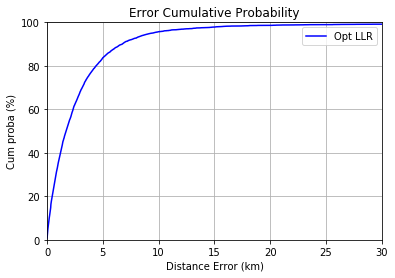

In [71]:
err_vec = Eval_geoloc(ground_truth_lat_device_out, ground_truth_lng_device_out, search_pred_lat_clf, search_pred_lng_clf)
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
# Error criterion
np.percentile(err_vec, 80)

Conclusion: 
We can see that the result of without device is almost the same than before. While reducing device can avoid overfit without impact too much to the prediction performance.

# Test

In [0]:
clf_pos = RandomForestRegressor(n_estimators=30).fit(df_train, ground_truth_pos_train)

In [0]:
y_pred = clf_pos.predict(df_test)

In [0]:
test_res = pd.DataFrame(y_pred)

In [0]:
test_res.columns = ['lat', 'lng']

In [0]:
test_res['messid'] = df_mess_test['messid']

In [94]:
test_res

,lat,lng,messid
0,39.767332,-105.078030,573be2503e952e191262c351
1,39.767893,-105.086567,573c05f83e952e1912758013
2,39.689037,-105.005298,573c05f83e952e1912758013
3,39.785287,-105.064152,573c05f83e952e1912758013
4,39.695356,-105.006181,573c05f83e952e1912758013
...,...,...,...
5289,39.730712,-104.984133,576b63b3e541cd2f80cddd80
5290,39.775767,-105.029015,576b6917e541cd2f80d0ffd0
5291,39.682053,-105.021865,576b6917e541cd2f80d0ffd0
5292,39.681793,-105.030014,576b6a9312f14316d567f9eb


In [0]:
test_res.to_csv('/content/drive/My Drive/IOT /pred_pos_test_list.csv', index=False)